# Comparing Kmeans Clusters vs. Community Detection

In [1]:
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import json
import sys

from batchup import data_source

from collections import Counter

from sklearn.cluster import KMeans, SpectralClustering

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from sklearn import metrics 
from scipy.spatial.distance import cdist

from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
#!pip install batchup
#!pip install matplotlib==3.1.0

### Load in Model, Validation Spectrograms and Labels

In [3]:
models_path = '/datasets/home/21/321/ee228sp20ta1/G51/models/'
val_path = '/datasets/home/21/321/ee228sp20ta1/G51/val_set.npy'
val_ids_path = '/datasets/home/21/321/ee228sp20ta1/G51/val_ids.txt'

### Tokenize Labels for validation spectrogram 

In [4]:
f=open(val_ids_path, "r")
val_spec_ids = f.read()
val_spec_labels = val_spec_ids.split('\n')
# type(val_spec_labels)

### Preprocess validation spectrograms

In [5]:
X_valid = np.load(val_path)

x_valid = X_valid[:,:,:216].copy()
x_valid = x_valid.reshape((2763*96,216))

unscaled_val_set = x_valid.reshape(2763,96,216,1)

print(x_valid.shape)

scaler = MinMaxScaler().fit(x_valid) 

scaled_valid = scaler.transform(x_valid)


s_valid_reshaped = scaled_valid.reshape(2763,96,216,1)
val_set = s_valid_reshaped

(265248, 216)


In [6]:
del X_valid, x_valid, scaled_valid

### Define Model Architecture(s)

In [7]:
def AE_01():
    
    #### Encoder ####
    model = models.Sequential()
    model.add(keras.Input(shape=(96,216,1)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(45, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #### Decoder ####
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(45, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D(size=(2,2)))
    model.add(layers.Conv2D(1,(3, 3), padding='same'))
    
    return model

### Load in Weights

In [8]:
AE = AE_01()

save_name = 'ae_01.1'

# Restore the weights
AE.load_weights(models_path+save_name)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Create Batches of Validation Spectrograms

In [9]:
ds = data_source.ArrayDataSource([val_set])

latent_vecs = []

get_hl = K.function([AE.layers[0].input], [AE.layers[6].output])

for batch in ds.batch_iterator(batch_size=64, shuffle=False):
    
    AE_h1 = get_hl([batch])[0]
    latent_vecs.append(AE_h1)
    
latent_vecs = asarray(latent_vecs)

latent_vecs = np.concatenate(latent_vecs)
#print(latent_vecs.shape)

### Reshape latent vectors

In [10]:
latent_vectors = np.ndarray(shape=(2763,72,72))

for idx, spec in enumerate(val_set):
    latent_vec = latent_vecs[idx].reshape(72, 72)
    latent_vectors[idx] = latent_vec
    
# print(latent_vectors.shape)

In [11]:
reshaped_latent_vectors = latent_vectors.reshape(2763,5184)
X = reshaped_latent_vectors

### Determine Optimal Number of Clusters

### 1. Silhouette Scoring

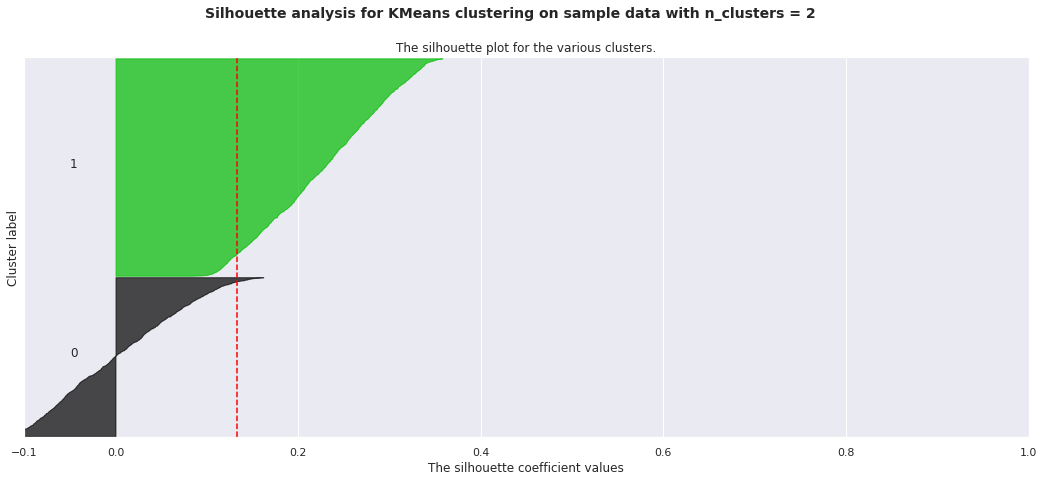

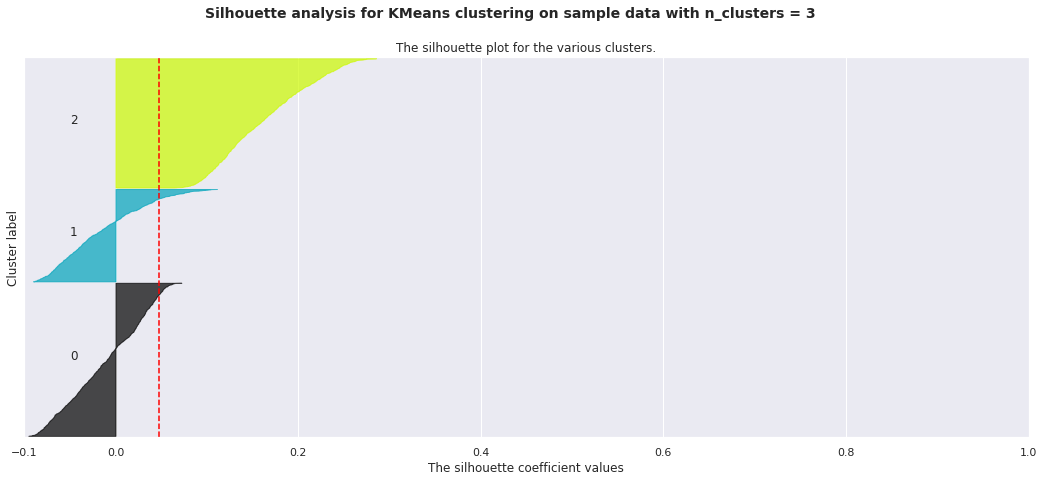

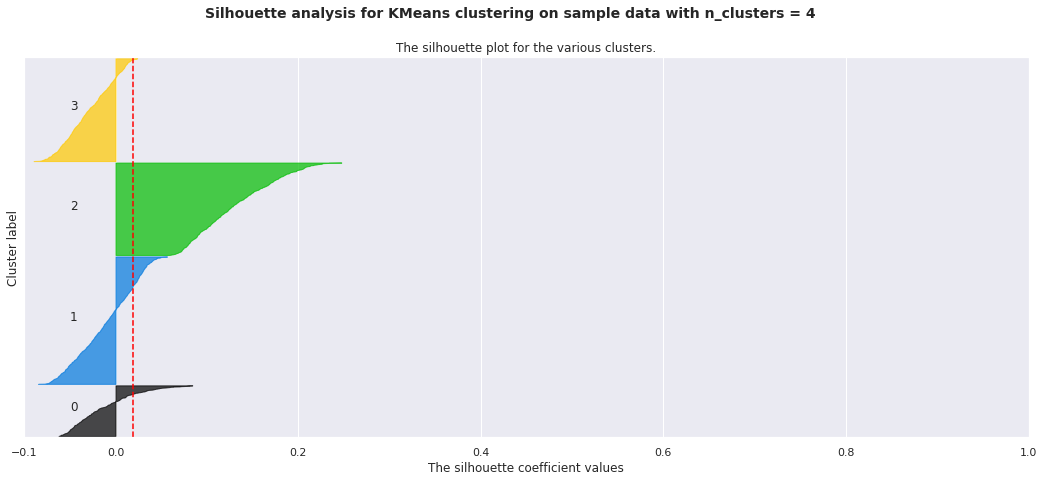

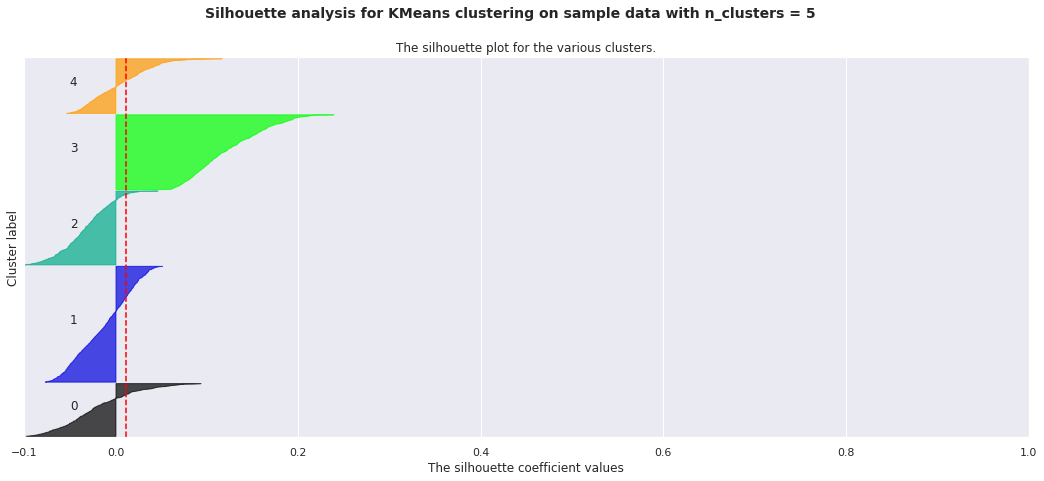

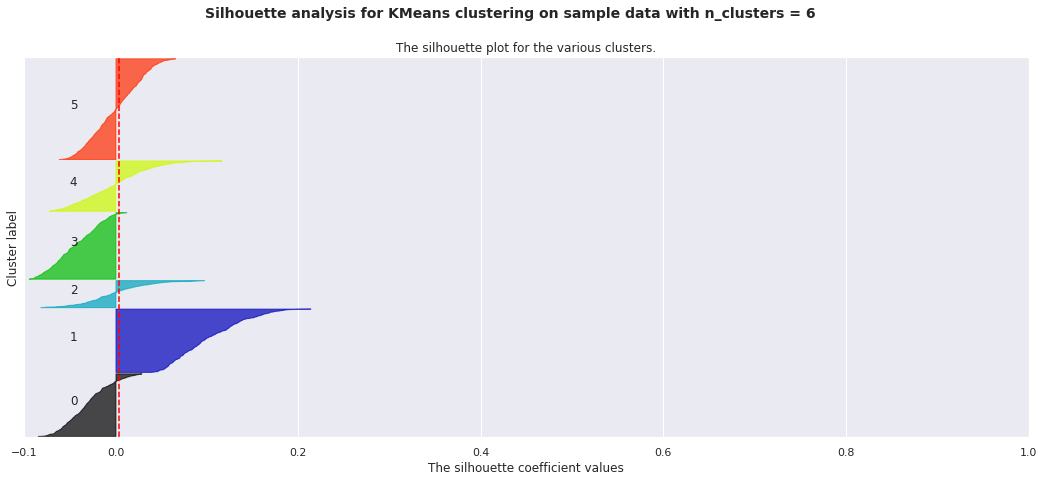

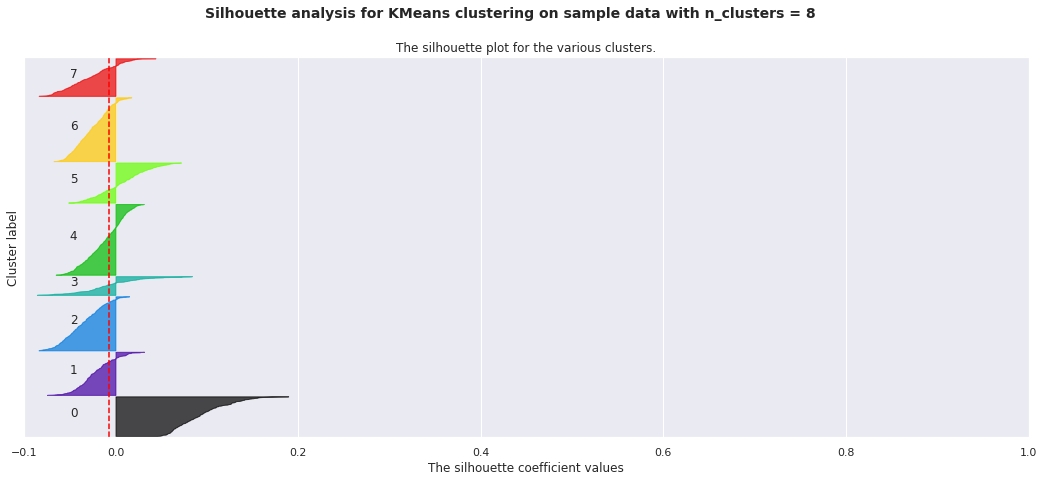

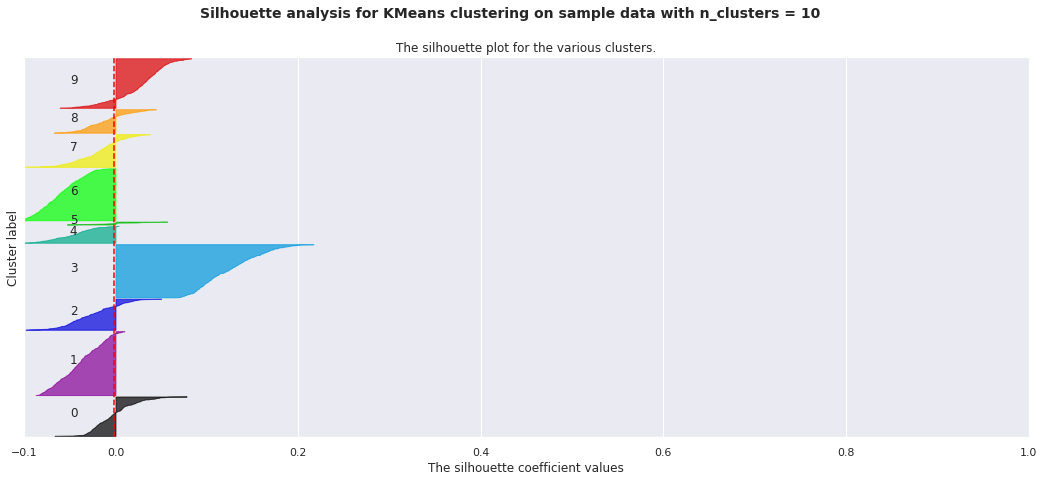

In [13]:
stdout_obj = sys.stdout             # store original stdout 

sys.stdout = open("{}_silhouette.txt".format(save_name), "w")

range_n_clusters = [2,3,4,5,6,8,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

sys.stdout.close()
sys.stdout = stdout_obj 

### 2. Elbo Method (distortion and interia)

In [14]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {}

range_n_clusters = [2,3,4,5,6,8,10]

for k in range_n_clusters:
    
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

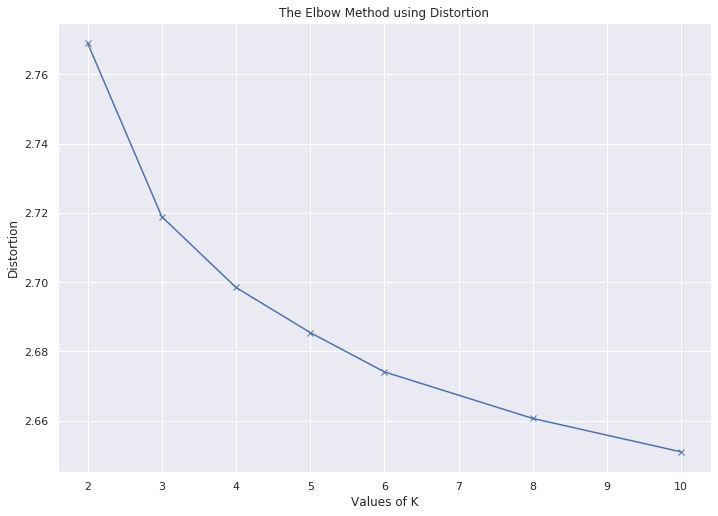

In [15]:
plt.plot(range_n_clusters, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.savefig('{}_elbow_distortion.png'.format(save_name), dpi=300, bbox_inches='tight')
plt.show() 

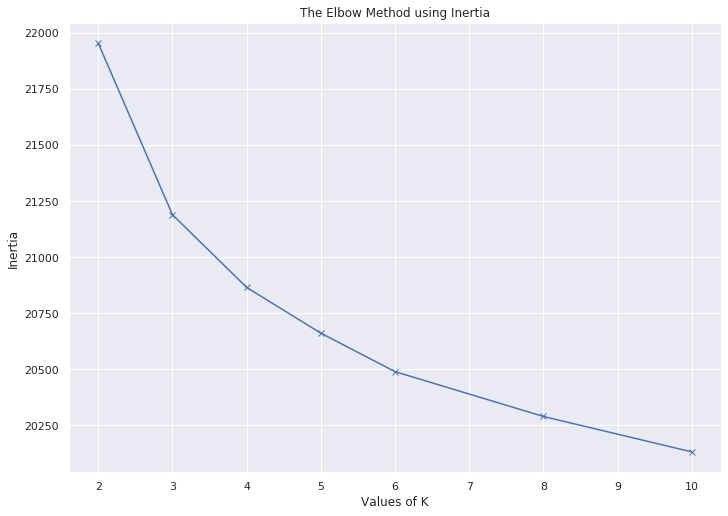

In [33]:
plt.plot(range_n_clusters, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.savefig('{}_elbow_inertia.png'.format(save_name), dpi=300, bbox_inches='tight')
plt.show() 

## Determine optimal number of clusters = nclusters

In [17]:
nclusters = 3

### Rerun Kmeans

In [18]:
kmeans = KMeans(n_clusters=nclusters, init='k-means++', verbose =1).fit(reshaped_latent_vectors)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 21882.565008030393
start iteration
done sorting
end inner loop
Iteration 1, inertia 21517.872205258624
start iteration
done sorting
end inner loop
Iteration 2, inertia 21420.687022654813
start iteration
done sorting
end inner loop
Iteration 3, inertia 21360.10842612431
start iteration
done sorting
end inner loop
Iteration 4, inertia 21313.568386901658
start iteration
done sorting
end inner loop
Iteration 5, inertia 21277.656921706654
start iteration
done sorting
end inner loop
Iteration 6, inertia 21251.080566901885
start iteration
done sorting
end inner loop
Iteration 7, inertia 21231.431631532207
start iteration
done sorting
end inner loop
Iteration 8, inertia 21220.019459950512
start iteration
done sorting
end inner loop
Iteration 9, inertia 21213.137131240084
start iteration
done sorting
end inner loop
Iteration 10, inertia 21207.69336566112
start iteration
done sorting
end inner loop
Iteration

### Obtain Kmeans cluster labels

In [19]:
cluster_labels = kmeans.labels_

# PAUSE HERE:

## 1. Go to Notebook 03_Community_Detection

## 2. Run igraph.leading_eigen_vector(clusters = nclusters )

## 3. Save out resulting communities.json (as instructed)

## 4. Return to this notebook and complete Clustering Analysis

## 5. Alternatively, try nclusters vs. various # of communities

### Load in Community Detection Labels

In [20]:
community_json = 'val_communities_3.json'

with open(community_json) as json_file:
    community_labels = json.load(json_file)

### Sort and Align Kmean labels and Community Labels

In [21]:
kmeans_labels = dict()
for idx, label in zip(val_spec_labels, cluster_labels):
    kmeans_labels[idx] = label

sorted_kmeans_labels = dict(sorted(kmeans_labels.items()))

sorted_community_labels = dict(sorted(community_labels.items()))

#This should be True
sorted_community_labels.keys() == sorted_kmeans_labels.keys()

True

### Define official Labels

In [22]:
community_labels = list(sorted_community_labels.values())
cluster_labels = list(sorted_kmeans_labels.values())

### Check overall class counts

In [23]:
Counter(community_labels)

Counter({0: 2706, 1: 28, 3: 20, 2: 9})

In [24]:
Counter(cluster_labels)

Counter({2: 1128, 1: 690, 0: 945})

### Dimensionality Reduction and Visualization

### 1. TSNE Manifold 

In [25]:
X_embedded = TSNE(n_components=2).fit_transform(reshaped_latent_vectors)

### TSNE with Kmeans Cluster Labels

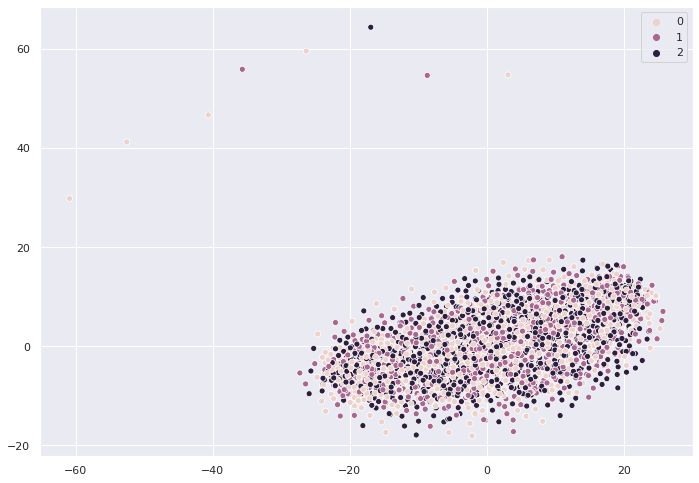

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cluster_labels, legend='full')
plt.savefig('{}_tnse_clusters.png'.format(save_name), dpi=300, bbox_inches='tight')


### TSNE with Community Detection Labels

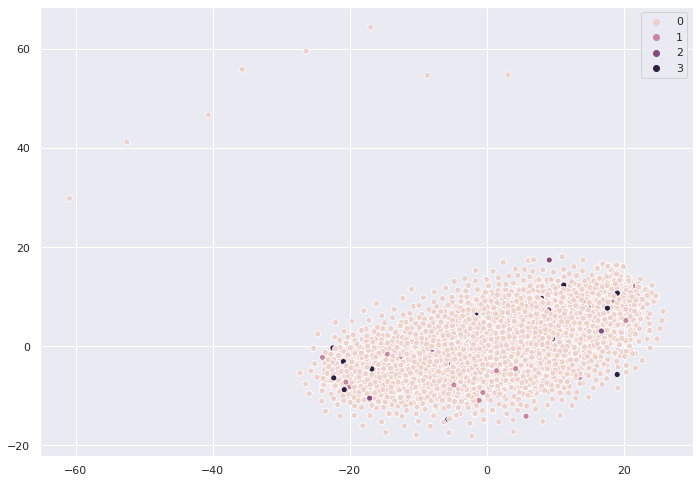

In [27]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=community_labels, legend='full')
plt.savefig('{}_tsne_community.png'.format(save_name), dpi=300, bbox_inches='tight')


### 2. Principle Component Analysis

In [28]:
df = pd.DataFrame()
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.18678853 0.02712051 0.01905945]


### Visualize PCA with Cluster Labels

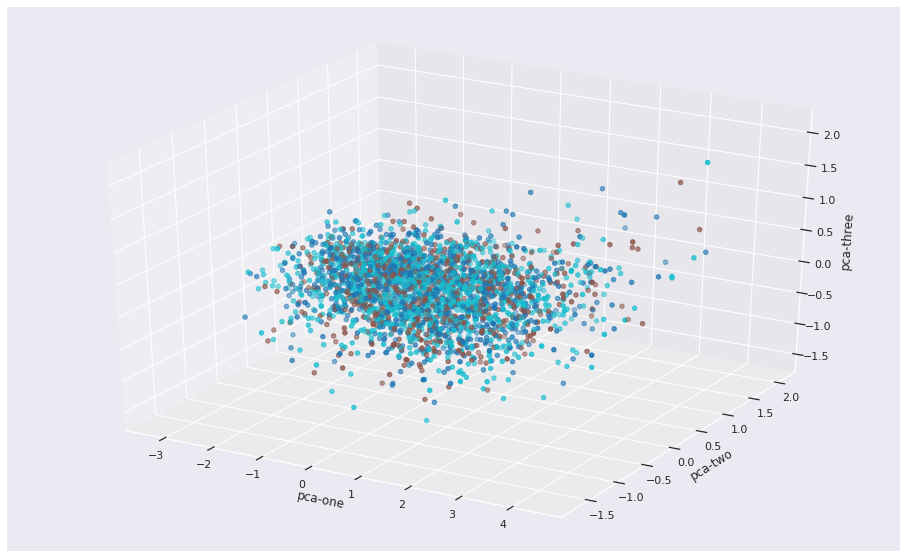

In [29]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,:]["pca-one"], 
    ys=df.loc[:,:]["pca-two"], 
    zs=df.loc[:,:]["pca-three"], 
    c=cluster_labels, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.savefig('{}_pca_clusters.png'.format(save_name), dpi=300, bbox_inches='tight')

plt.show()

### Visualize PCA with Community Labels

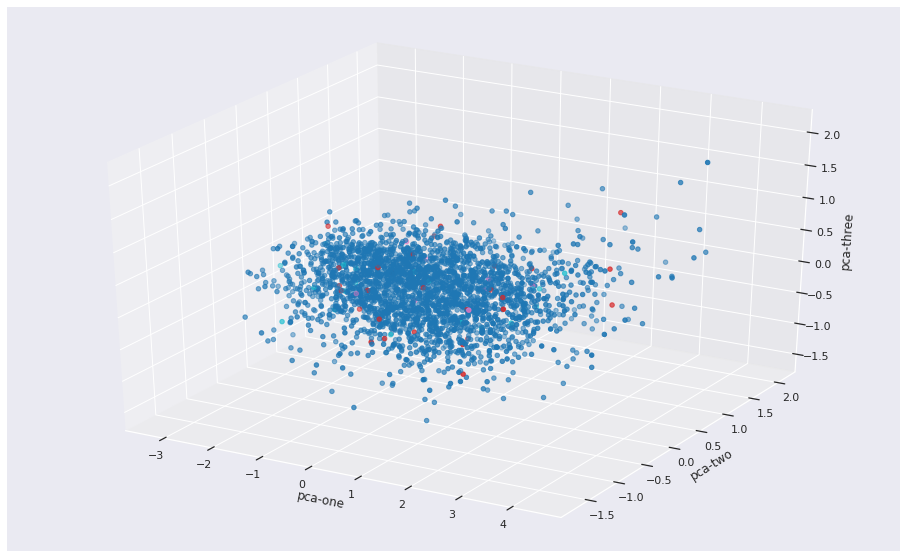

In [30]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[:,:]["pca-one"], 
    ys=df.loc[:,:]["pca-two"], 
    zs=df.loc[:,:]["pca-three"], 
    c=community_labels, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.savefig('{}_pca_community.png'.format(save_name), dpi=300, bbox_inches='tight')
plt.show()

### Plot Confusion Matrix

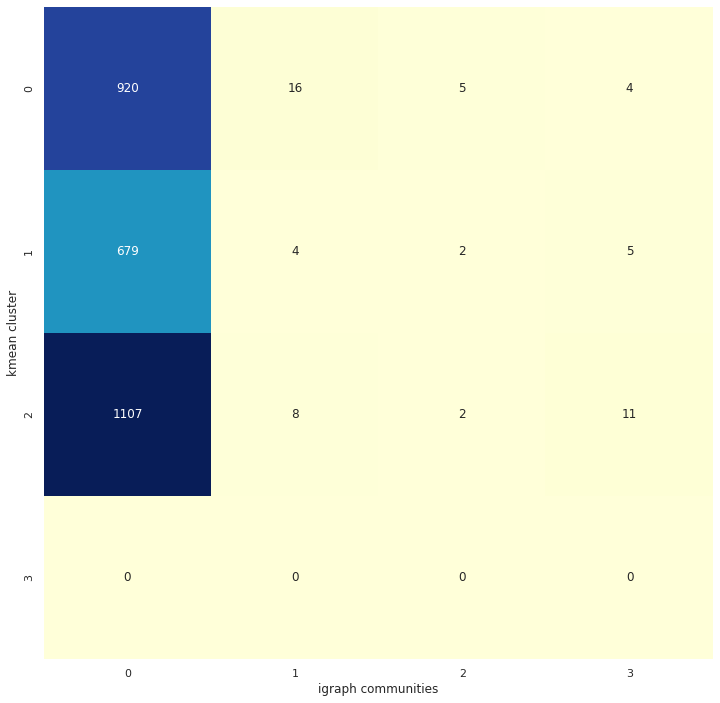

In [31]:
labels = kmeans.labels_
community = list(sorted_community_labels.values())
kmeanclusters = list(sorted_kmeans_labels.values())

mat = confusion_matrix(community, kmeanclusters)
fig, ax = plt.subplots(figsize=(12,12))  

sns.heatmap(mat.T, square=False, annot=True, fmt='d', cbar=False, cmap="YlGnBu", ax=ax)
plt.xlabel('igraph communities')
plt.ylabel('kmean cluster');
plt.savefig('{}_confusion_matrix.png'.format(save_name), dpi=300, bbox_inches='tight')
